In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

## Read in the Data

The data is from a public dataset on Kaggle: https://www.kaggle.com/jmmvutu/summer-products-and-sales-in-ecommerce-wish, and it is generated from crawling the result page after searching “summer” on Wish. The data was
collected in August 2020

In [2]:
sales = pd.read_csv('data/summer-products-with-rating-and-performance_2020-08.csv')
sales.head()

,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,...,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,EUR,100,0,3.76,54,26.0,...,568,4.128521,595097d6a26f6e070cb878d1,0,NaN,https://www.wish.com/c/5e9ae51d43d6a96e303acdb0,https://contestimg.wish.com/api/webimage/5e9ae...,5e9ae51d43d6a96e303acdb0,summer,2020-08
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,EUR,20000,1,3.45,6135,2269.0,...,17752,3.899673,56458aa03a698c35c9050988,0,NaN,https://www.wish.com/c/58940d436a0d3d5da4e95a38,https://contestimg.wish.com/api/webimage/58940...,58940d436a0d3d5da4e95a38,summer,2020-08
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,2020 New Arrival Women Spring and Summer Beach...,8.00,43,EUR,100,0,3.57,14,5.0,...,295,3.989831,5d464a1ffdf7bc44ee933c65,0,NaN,https://www.wish.com/c/5ea10e2c617580260d55310a,https://contestimg.wish.com/api/webimage/5ea10...,5ea10e2c617580260d55310a,summer,2020-08
3,Hot Summer Cool T-shirt pour les femmes Mode T...,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,EUR,5000,1,4.03,579,295.0,...,23832,4.020435,58cfdefdacb37b556efdff7c,0,NaN,https://www.wish.com/c/5cedf17ad1d44c52c59e4aca,https://contestimg.wish.com/api/webimage/5cedf...,5cedf17ad1d44c52c59e4aca,summer,2020-08
4,Femmes Shorts d'été à lacets taille élastique ...,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,EUR,100,1,3.10,20,6.0,...,14482,4.001588,5ab3b592c3911a095ad5dadb,0,NaN,https://www.wish.com/c/5ebf5819ebac372b070b0e70,https://contestimg.wish.com/api/webimage/5ebf5...,5ebf5819ebac372b070b0e70,summer,2020-08


In [3]:
print("The Wish summer sales data has {} entries and {} columns".format(sales.shape[0], sales.shape[1]))

The Wish summer sales data has 1573 entries and 43 columns


In [4]:
sales.info() #check the data type and see if there's any NAs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         1573 non-null   object 
 1   title_orig                    1573 non-null   object 
 2   price                         1573 non-null   float64
 3   retail_price                  1573 non-null   int64  
 4   currency_buyer                1573 non-null   object 
 5   units_sold                    1573 non-null   int64  
 6   uses_ad_boosts                1573 non-null   int64  
 7   rating                        1573 non-null   float64
 8   rating_count                  1573 non-null   int64  
 9   rating_five_count             1528 non-null   float64
 10  rating_four_count             1528 non-null   float64
 11  rating_three_count            1528 non-null   float64
 12  rating_two_count              1528 non-null   float64
 13  rat

Most columns look good. However, there are a few columns missing a lot of data:
- has_urgency_banner
- urgency_text
- merchant_profile_picture
We will need to handle these columns later

## Data Validation

### Check Duplicated Entries

In [5]:
sales_duplicate = sales.duplicated()
sales_duplicate_row = sales_duplicate[sales_duplicate==True]
print("There are {} number of duplicated entries in the sales dataset".format(len(sales_duplicate_row)))

There are 34 number of duplicated entries in the sales dataset


In [6]:
##drop the duplicated rows
sales_no_duplicate = sales.drop(sales_duplicate_row.index, axis=0)
print("The Wish summer sales data has {} entries and {} columns after removing duplicated rows".format
                                                                  (sales_no_duplicate.shape[0], sales_no_duplicate.shape[1]))

The Wish summer sales data has 1539 entries and 43 columns after removing duplicated rows


### Handle Missing Values

In [7]:
def count_na_by_column(df):
    na_count = df.isna().sum() #show columns which have missing entry 
    na_columns = na_count[na_count!=0].sort_values()
    return na_columns 

In [8]:
na_columns = count_na_by_column(sales_no_duplicate)

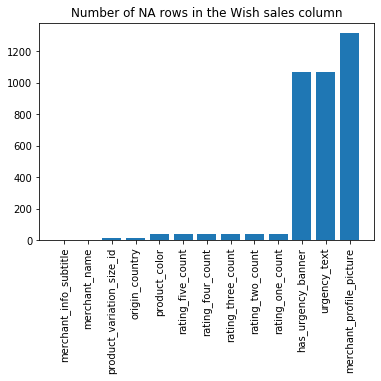

In [9]:
%matplotlib inline
plt.bar(x=na_columns.index, height=na_columns.values)
plt.xticks(rotation=90)
plt.title('Number of NA rows in the Wish sales column');

### rating_{N}_count columns

The ```rating_{N}_count``` columns show the number of ratings which have N-star. For example, ```rating_two_count``` indicates the number of 2-star ratings for a product. Therefore, the NA in ```rating_two_count``` means there's no 2-start rating, and we can simply replace the NA with 0

In [10]:
r = re.compile("rating_\w+_count")
rating_col = list(filter(r.match, sales_no_duplicate.columns.values)) #find column names for rating_N_count
rating_df = sales_no_duplicate[rating_col].fillna(0)

### has_urgency_banner and urgency_text
The ```has_urgency_banner``` shows whether there was an urgency banner with an ```urgency_text``` for a product.The NA means there's no urgency banner.

In [11]:
print("urgency_text has values:",set(sales_no_duplicate["urgency_text"]))

urgency_text has values: {nan, 'Quantité limitée !', 'Réduction sur les achats en gros'}


The ```urgency_text``` are in French, and it only has three categories,  'Quantité limitée !' (Limited quantity), 'Réduction sur les achats en gros' (Discount on wholesale purchases), and nan. Hence, we can use one_hot_encoding to transfrom the ```urgency_text``` and simply drop the ```has_urgency_banner```

In [12]:
urgency_encoding = pd.get_dummies(sales_no_duplicate["urgency_text"], dummy_na=True) #apply one hot encoding on the urgency_text
urgency_encoding.columns = ['limited_quantity','discount','no_urgency']

### merchant_profile_picture
The```merchant_profile_picture``` has the link to custom profile picture of the seller (if the seller has one), otherwise it is NA. Luckily, there's a column ```merchant_has_profile_picture``` for showing whether the seller has a profile picture. We can drop the ```merchant_profile_picture``` 

In [13]:
drop_columns = ["urgency_text", "has_urgency_banner", "merchant_profile_picture"] + rating_col
sales_clean = sales_no_duplicate.drop(drop_columns, axis=1) #drop urgency_text, has_urgency_banner, merchant_profile_picture 

### product_color

In [14]:
product_color = sales_clean["product_color"]
Counter(product_color.str.lower()).most_common() #sort the product_color based on their frequencies

[('black', 301),
 ('white', 249),
 ('yellow', 101),
 ('pink', 99),
 ('blue', 97),
 ('red', 93),
 ('green', 86),
 ('grey', 70),
 ('purple', 53),
 (nan, 41),
 ('armygreen', 31),
 ('navyblue', 27),
 ('orange', 27),
 ('winered', 27),
 ('multicolor', 20),
 ('beige', 14),
 ('lightblue', 12),
 ('khaki', 12),
 ('white & green', 10),
 ('gray', 10),
 ('skyblue', 8),
 ('rosered', 8),
 ('brown', 7),
 ('coffee', 6),
 ('darkblue', 6),
 ('floral', 5),
 ('rose', 5),
 ('black & green', 4),
 ('lightpink', 4),
 ('leopard', 4),
 ('fluorescentgreen', 3),
 ('camouflage', 3),
 ('army green', 3),
 ('lightgreen', 3),
 ('black & white', 3),
 ('orange-red', 3),
 ('navy', 3),
 ('whitefloral', 2),
 ('lightyellow', 2),
 ('coolblack', 2),
 ('pink & black', 2),
 ('silver', 2),
 ('mintgreen', 2),
 ('pink & grey', 2),
 ('dustypink', 2),
 ('white & black', 2),
 ('apricot', 2),
 ('burgundy', 2),
 ('pink & white', 2),
 ('navy blue', 2),
 ('lightred', 2),
 ('lakeblue', 2),
 ('camel', 2),
 ('pink & blue', 2),
 ('applegreen'

White and black products count about 35% of the dataset in total. We can classify other color types as a thrid category. Then, apply one hot encoding on the product_color variable

In [15]:
sales_clean["product_color"]

0              white
1              green
2       leopardprint
3              black
4             yellow
            ...     
1568        navyblue
1569       lightblue
1570           white
1571           white
1572             red
Name: product_color, Length: 1539, dtype: object

In [16]:
sales_clean["product_color"]=sales_clean["product_color"].map(lambda x: x.lower() if isinstance(x,str) else x) #transform all the string to lower case
sales_clean.loc[(sales_clean.product_color!="white") & (sales_clean.product_color!="black"), "product_color"] = "other"

In [17]:
print("Now the product_color has 3 types:",set(sales_clean["product_color"]))

Now the product_color has 3 types: {'black', 'other', 'white'}


In [18]:
#apply one_hot_encoding on the product_color column
color_encoding = pd.get_dummies(sales_clean["product_color"],prefix="color") 
sales_no_color=sales_clean.drop("product_color", axis=1) #drop the orginal product_color column

### origin_country


In [19]:
origin_country = sales_no_color["origin_country"]
Counter(origin_country.str.lower()).most_common()

[('cn', 1484),
 ('us', 31),
 (nan, 16),
 ('ve', 4),
 ('sg', 2),
 ('at', 1),
 ('gb', 1)]

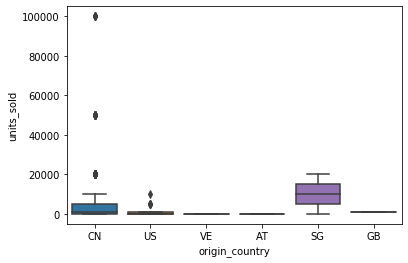

In [20]:
sns.boxplot(y="units_sold", x="origin_country", data=sales_no_color);

In [21]:
sales_no_color["origin_country"] = sales_no_color["origin_country"].map(lambda x: x.lower() if isinstance(x,str) else x) #transform all the string to lower case

#convert the origin_country column to a binary categorical column -- China (1) Other(0)
sales_no_color.loc[sales_no_color.origin_country != "cn", "origin_country"]= 0
sales_no_color.loc[sales_no_color.origin_country != 0, "origin_country"]= 1

In [22]:
sales_no_color.rename(columns = {"origin_country":"origin_china"}, inplace=True)
print("Now the origin_country has 2 categories:",set(sales_no_color["origin_china"]))

Now the origin_country has 2 categories: {0, 1}


### product_variation_size_id

In [23]:
product_size = sales_no_color["product_variation_size_id"]
Counter(product_size.str.lower()).most_common()

[('s', 635),
 ('xs', 344),
 ('m', 198),
 ('xxs', 94),
 ('l', 49),
 ('xl', 17),
 ('s.', 16),
 ('xxl', 15),
 (nan, 14),
 ('size s', 8),
 ('xxxs', 6),
 ('xs.', 5),
 ('4xl', 5),
 ('size-xs', 4),
 ('m.', 4),
 ('size xs', 4),
 ('2xl', 4),
 ('2pcs', 3),
 ('33', 3),
 ('sizel', 3),
 ('34', 3),
 ('size-xxs', 3),
 ('size-s', 3),
 ('10 ml', 3),
 ('suit-s', 2),
 ('xxxxxl', 2),
 ('eu 35', 2),
 ('size s.', 2),
 ('3xl', 2),
 ('size xxs', 2),
 ('29', 2),
 ('one size', 2),
 ('1', 2),
 ('5xl', 2),
 ('size m', 2),
 ('xxxxl', 2),
 ('35', 2),
 ('s(bust 88cm)', 2),
 ('size -xxs', 2),
 ('1 pc.', 2),
 ('s pink', 2),
 ('size4xl', 2),
 ('choose a size', 1),
 ('32/l', 1),
 ('4', 1),
 ('1m by 3m', 1),
 ('women size 36', 1),
 ('us 6.5 (eu 37)', 1),
 ('26(waist 72cm 28inch)', 1),
 ('1pc', 1),
 ('100 cm', 1),
 ('size-4xl', 1),
 ('s/m(child)', 1),
 ('xxxl', 1),
 ('s..', 1),
 ('30 cm', 1),
 ('100 x 100cm(39.3 x 39.3inch)', 1),
 ('100pcs', 1),
 ('base & top & matte top coat', 1),
 ('s (waist58-62cm)', 1),
 ('s(pink & bl

Transfrom the product size into 4 categories: s, m xs, and other

In [24]:
sales_no_color["product_variation_size_id"]=sales_no_color["product_variation_size_id"].map(lambda x: x.lower() if isinstance(x,str) else x) #transform all the string to lower case
sales_no_color.loc[~sales_no_color.product_variation_size_id.isin(['s', 'm', 'xs']), "product_variation_size_id"]= "other"

In [25]:
print("Now the product_variation_size_id has 4 types:",set(sales_no_color["product_variation_size_id"]))

Now the product_variation_size_id has 4 types: {'xs', 's', 'm', 'other'}


In [26]:
size_encoding = pd.get_dummies(sales_no_color["product_variation_size_id"], prefix='size') 
sales_no_size=sales_no_color.drop("product_variation_size_id", axis=1) #drop the orginal product_variation_size_id column

```merchant_info_subtitle``` is the subtitle text as shown on a seller's info section to the user. ```merchant_name``` is merchant's canonical name, and it won't be shown to the customer. We will not need these two columns for our model, so we can drop them now.

In [27]:
sales_no_merchant = sales_no_size.drop(["merchant_info_subtitle", "merchant_name"], axis=1)

In [28]:
#concatnate the transformed rating_N_counts and one_hot_encoding urgency columns to the orginal dataframe 
sales_all = pd.concat([sales_no_merchant, urgency_encoding, rating_df, color_encoding, size_encoding], axis=1) 

In [29]:
sales_all.isnull().values.any() #check if there's any NA value remaining in the dataset

False

## Remove irrelevant columns

Some columns in the dataset are not meaningful for our project. They can be removed:

- theme: the search term used in the search bar of the website to get these search results.In our case, it is just "summer"
- crawl_month: when the data set is generated 
- product_id: product identifier
- product_picture
- product_url
- merchant_id : merchant unique id
- merchant_title: Merchant's displayed name (show in the UI as the seller's shop name)
- currecy_buyer: currecnt of the prices, which is just "EUR" in this dataset
- title: Title for localized for european countries. May be the same as title_orig if the seller did not offer a translation
- title_orig: Original english title of the product

In [31]:
remove_columns = ['theme', 'crawl_month', 'product_id', 'product_picture','product_url', 'merchant_id', 'merchant_title',
                 'currency_buyer','title','title_orig']
sale_final = sales_all.drop(remove_columns, axis=1)

In [32]:
sale_final.head()

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,...,rating_three_count,rating_two_count,rating_one_count,color_black,color_other,color_white,size_m,size_other,size_s,size_xs
0,16.00,14,100,0,3.76,54,0,0,0,0,...,10.0,1.0,9.0,0,0,1,1,0,0,0
1,8.00,22,20000,1,3.45,6135,0,0,0,0,...,1118.0,644.0,1077.0,0,1,0,0,0,0,1
2,8.00,43,100,0,3.57,14,0,0,0,0,...,2.0,0.0,3.0,0,1,0,0,0,0,1
3,8.00,8,5000,1,4.03,579,0,0,0,0,...,87.0,42.0,36.0,1,0,0,1,0,0,0
4,2.72,3,100,1,3.10,20,0,0,0,0,...,2.0,2.0,6.0,0,1,0,0,0,1,0


In [33]:
sale_final.columns

Index(['price', 'retail_price', 'units_sold', 'uses_ad_boosts', 'rating',
       'rating_count', 'badges_count', 'badge_local_product',
       'badge_product_quality', 'badge_fast_shipping', 'tags',
       'product_variation_inventory', 'shipping_option_name',
       'shipping_option_price', 'shipping_is_express', 'countries_shipped_to',
       'inventory_total', 'origin_china', 'merchant_rating_count',
       'merchant_rating', 'merchant_has_profile_picture', 'limited_quantity',
       'discount', 'no_urgency', 'rating_five_count', 'rating_four_count',
       'rating_three_count', 'rating_two_count', 'rating_one_count',
       'color_black', 'color_other', 'color_white', 'size_m', 'size_other',
       'size_s', 'size_xs'],
      dtype='object')

## Save the cleaned data to local

In [35]:
sale_final.to_csv('data/wish_sales_clean.csv', index=False)